# Segmentation of ecommerce customers


# Table of Contents:
   
- [1. Introduction](#first-bullet)
- [2. Reading the file](#second-bullet)
- [3. EDA](#EDA)
    - [3.1. Keyword study](#KW)
- [4. Data engineering](#pre)    
- [5. Clustering](#clus)
    - [5.1 Elbow method](#elb)
    - [5.2 PCA](#pca)
-[6. Conclusions](#con)    


In [1]:
pip install wordcloud

In [2]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas_profiling

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import datetime, nltk, warnings
import gc
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline




import warnings
# current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

import missingno as msno # missing data visualization module for Python



%matplotlib inline
color = sns.color_palette()


pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 100)


# Auxiliar functions

In [5]:
#Function to detect substitute the rare lables
def rare_encoding(X_train, X_test, variable, tolerance):

    X_train = X_train.copy()
    X_test = X_test.copy()

    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)

    # re-group rare labels
    X_train[variable] = np.where(X_train[variable].isin(
        frequent_cat), X_train[variable], 'Rare')
    
    X_test[variable] = np.where(X_test[variable].isin(
        frequent_cat), X_test[variable], 'Rare')

    return X_train, X_test
    
################################################################################################################################

#Function to detect the rare labels
def find_non_rare_labels(df, variable, tolerance):
    
    temp = df.groupby([variable])[variable].count() / len(df)
    
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    
    return non_rare
################################################################################################################################

#Function to return a pivot table relating two variables
def Pivot_Table(X_train,y_train,variable):
    X_train['target'] = y_train
    
    temp = X_train[[variable, 'target']].groupby([variable],
                                                    as_index=False).mean().sort_values(by='target', ascending=False)
    
    X_train.drop('target',axis=1,inplace = True)
    
    return temp

################################################################################################################################

#Function to plot distributions   
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable],fit=norm, bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()
    
################################################################################################################################
    
#Function to plot densities to compare imputed features with originals   
def DensityPlots(X_train, X_test, X_train_imputed,X_test_imputed, variable):
    # plot the distribution of the imputed variable

    fig = plt.figure(figsize=(16, 4))


    ax = fig.add_subplot(131)

    X_train[variable].plot(kind='kde', ax=ax, color='orange')
    X_train_imputed[variable].plot(kind='kde', ax=ax, color='black')

    # add legends
    lines, labels = ax.get_legend_handles_labels()
    labels = ['train orig', 'train imp']
    ax.legend(lines, labels, loc='best')
    plt.title(variable +' train distribution')

    #Second image
    ay = fig.add_subplot(132)

    X_test[variable].plot(kind='kde', ax=ay, color='orange')
    X_test_imputed[variable].plot(kind='kde', ax=ay, color='black')

    # add legends
    lines, labels = ay.get_legend_handles_labels()
    labels2 = ['test orig', 'test imp']
    ay.legend(lines, labels2, loc='best')
    plt.title(variable +' test distribution')

    plt.show()
    
################################################################################################################################
   
#Function that returns features with less categories than the tolerance    
def FewCategories (X_train, tol) :

    columns = []
    
    for i in X_train.columns:
    
        if(X_train[i].value_counts().count() <= tol):
            columns.append(i)
            
            
    return columns

################################################################################################################################

#Function that returns features with more categories than the tolerance
def ManyCategories (X_train, tol) :
    
    columns = []
    
    for i in X_train.columns:
    
        if(X_train[i].value_counts().count() >= tol):
            columns.append(i)
            
            
    return columns

################################################################################################################################

#Function to fit and cross validate the algorithm
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    scores = cross_val_score(algo, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    # Cross Validation 
    
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = np.sqrt((-1)* scores).mean()
    
    return train_pred, scores, acc_cv

################################################################################################################################

#Function that plots relationships from the target and a variable
def Relationships (X_train, y_train, variables):
    temp = X_train
    temp['target'] = y_train
    for var in X_train[variables].columns:

        fig = plt.figure()
        fig = X_train.groupby([var])['target'].mean().plot()
        fig.set_title('Relationship between {} and target'.format(var))
        fig.set_ylabel('Mean value of target')
        plt.show()
        
################################################################################################################################
  
#Function that returns a dictionary with the mappings for ordered encoding
def find_category_mappings(df, variable, target):

    # first  we generate an ordered list with the labels
    ordered_labels = df.groupby([variable
                                 ])[target].mean().sort_values().index

    # return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}

################################################################################################################################

#Function that does the encoding based on a map
def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)
    
################################################################################################################################

#Finds the boundaries for outliers
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

################################################################################################################################

#Function that returns the informations of a dataset. Perfect for the first look.
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: x.unique())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)
        str.columns = cols

    else:
        corr = df.corr()[pred]
        #str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        #cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
        data = {'types': types, 'counts': counts, 'distincts': distincts,
                'nulls':nulls, 'missing_ration':missing_ration,
                'uniques':uniques, 'skewness':skewness, 'kurtosis':kurtosis, corr_col:corr }
        str = pd.DataFrame(data) 
        
    
   
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

################################################################################################################################

#Returns the correlation table for the features in a model
def Correlation_Table(X_train, model):

    coeff_df = pd.DataFrame(X_train.columns.delete(0))
    coeff_df.columns = ['Feature']
    coeff_df["Correlation"] = pd.Series(model.coef_)

    return coeff_df.sort_values(by='Correlation', ascending=False)

################################################################################################################################

#Returns the correlation plot in a heatmap

def Correlation_Plot(X_train,y_train,variables):
    sns.heatmap(pd.concat([X_train[variables], y_train], axis=1).corr(),
                annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},cmap="plasma",ax=ax)
    ax.set_title("Correlation Plot")
    plt.show()
    
################################################################################################################################

#Plots the comparison between variables befor and after transformation  
def transformation_skew (X, kind='log'):
    import feature_engine.transformation as vt

    if (kind == 'log'):
        X_unsk = X.apply(lambda x: np.log(1+x)) # X_unsk --> Unskewed X
    if(kind == 'boxcox'):
        positives = []
        for var in X.columns:
            if ((X[var]>0).astype(int).sum() == X[var].count()):
                positives.append(var)
                
        bct = vt.BoxCoxTransformer(variables = positives)
        bct.fit(X)
        X_unsk = bct.transform(X)
    if(kind == 'yj'):
        yjt = vt.YeoJohnsonTransformer()
        yjt.fit(X)
        X_unsk = yjt.transform(X)

    X_unsk_vals = X_unsk.skew()             # X_unsk_vals --> Skew coefficients of X_unsk

    ax = sns.barplot(x=X.skew().values, y=X.skew().index, alpha=0.2)
    ax2 = ax.twinx()
    sns.barplot(x=X_unsk_vals.values, y=X_unsk_vals.index, ax=ax2)
    plt.show()

<a class="anchor" id="second-bullet"></a>
# 2. Reading the file

In [6]:
#df will remain untouched
df = pd.read_csv('data.csv', encoding = 'ISO-8859-1')

df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})

df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.isnull().sum().sort_values(ascending = False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


<a class="anchor" id="EDA"></a>
# 3. Exploratory data analysis


In [9]:
df['invoice_date'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

In [10]:
#Separating month and day to plot 
df_new = df.dropna()
df_new = df_new[df_new.Quantity > 0]
df_new['amount_spent'] = df_new['Quantity'] * df_new['UnitPrice']


df_new.insert(loc=2, column='year_month', value=df_new['invoice_date'].map(lambda x: 100*x.year + x.month))
df_new.insert(loc=3, column='month', value=df_new.invoice_date.dt.month)
# +1 to make Monday=1.....until Sunday=7
df_new.insert(loc=4, column='day', value=(df_new.invoice_date.dt.dayofweek)+1)
df_new.insert(loc=5, column='hour', value=df_new.invoice_date.dt.hour)

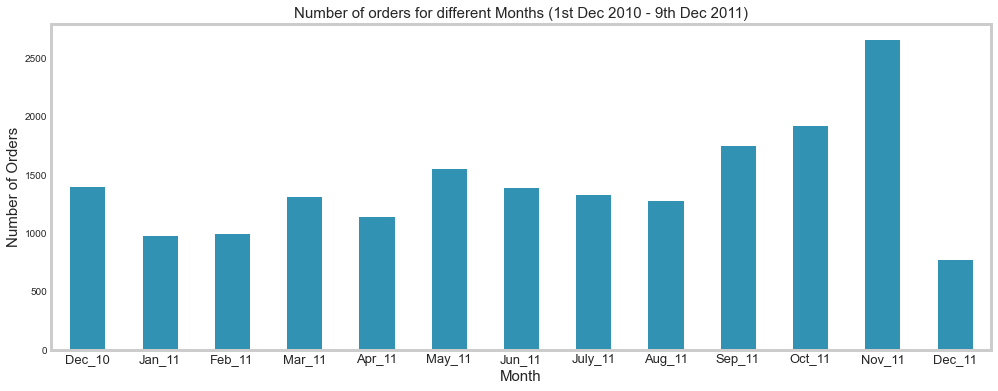

In [11]:
#Orders per month
ax = df_new.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind = 'bar',
                                                                                         color='#3192B3',figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11',
                    'Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.grid(False)
plt.show()

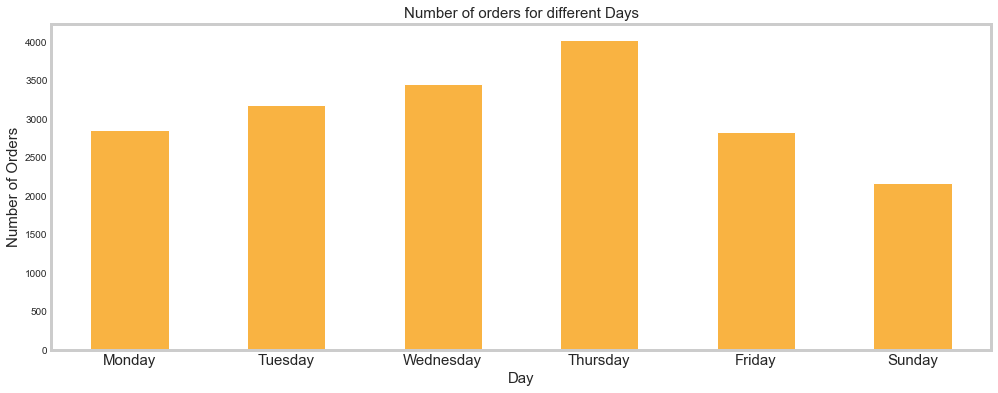

In [12]:
#Orders per day of the week
ax = df_new.groupby('InvoiceNo')['day'].unique().value_counts().sort_index().plot(kind = 'bar',figsize=(15,6),
                                                                                  color = '#F9b342')
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Monday','Tuesday','Wednesday','Thursday','Friday','Sunday'), rotation='horizontal', fontsize=15)
plt.grid(False)
plt.show()

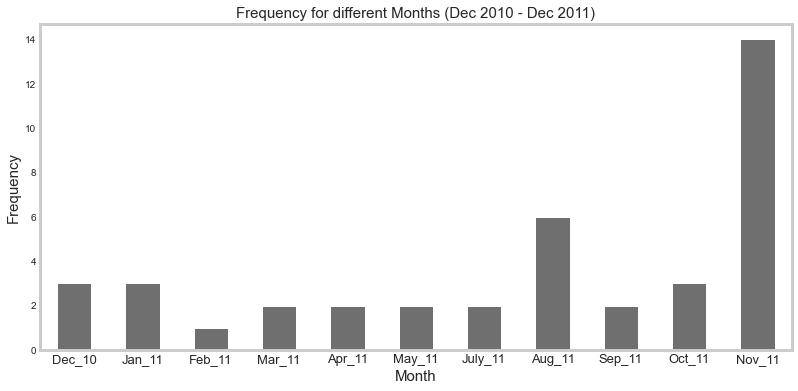

In [13]:
#Checking free items and how often they're given
df_free = df_new[df_new.UnitPrice == 0]
ax = df_free.year_month.value_counts().sort_index().plot(kind = 'bar',figsize=(12,6), color='#706f6f')
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11',
                    'Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=13)
plt.grid(False)
plt.show()

In [14]:
#Let's start to use od df_initial and drop the orders with no customer ID

df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
df_initial.isnull().sum().sort_values(ascending = False)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [15]:
#Let's remove the duplicates
print('removed rows: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

removed rows: 5225


In [16]:
#Let's take a look at the countries
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of different countries: {}'.format(len(countries)))

Number of different countries: 37


In [17]:
#We can explore a chloropleth map
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order no.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False
           )
#_______________________
layout = dict(title='Orders per country in a map',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [18]:
#Investigating how many unique values are there in some columns
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }],
             columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [19]:
#Investigating the number of products in each purchase
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

#With these informations, we already have a brief idea of some clusters

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


In [20]:
#Dealing with the cancelation (C starting the InvoiceNo)

nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket.head())
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [21]:
#Note that when we have a canceled order, we sometimes have a "duplicate" of it before, but with the positive quantity.
#There are some orders made before dec 2010 that have been canceled and are on the dataset, so they don't have the counterparts

df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

In [22]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


In [23]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

#These are canceled orders without previous activity by the customer

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [24]:
#Let's analyse stock code and look only for the letters
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [25]:
#We need to create a variable storing the total price of the purchases
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


In [26]:
#But this still isn't ideal. Let's try to compute the total amount per order

#___________________________________________
# sum
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date 
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')


,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
...,...,...,...,...
18619,18283,557956,192.80,2011-06-23 19:20:00.000000000
18628,18283,580872,208.00,2011-12-06 12:02:00.000001792
18630,18287,570715,1001.32,2011-10-12 10:22:59.999998720
18629,18287,554065,765.28,2011-05-22 10:38:59.999998976


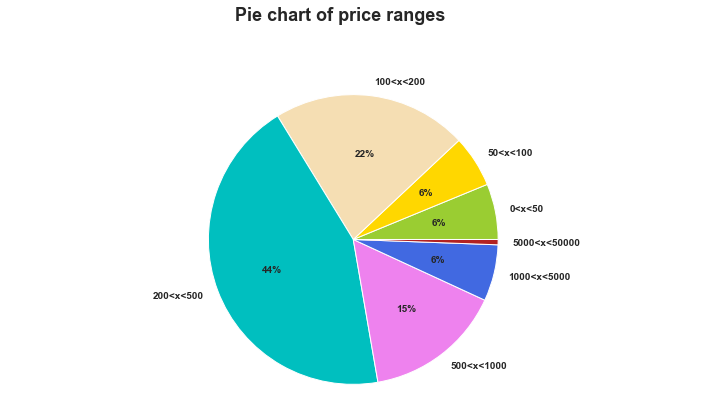

In [27]:
#Let's visualize the purchases in price intervals
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<x<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Pie chart of price ranges", ha='center', fontsize = 18);

<a class="anchor" id="KW"></a>
## 3.1. Keywords study 

In [28]:
#Now, let's try to extract the keywords from the description.

is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [29]:
#Now, to call the function
#Downloading packages from nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#Calling the function

df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Number of keywords in variable 'Description': 1483


In [30]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)
list_products

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['pink', 189],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121],
 ['holder', 120],
 ['flower', 120],
 ['decoration', 109],
 ['metal', 99],
 ['retrospot', 90],
 ['card', 90],
 ['necklac', 85],
 ['paper', 84],
 ['blue', 80],
 ['art', 75],
 ['silver', 72],
 ['cake', 70],
 ['polkadot', 68],
 ['cover', 68],
 ['mug', 66],
 ['tin', 66],
 ['wrap', 65],
 ['sign', 64],
 ['pack', 61],
 ['egg', 61],
 ['bracelet', 61],
 ['star', 59],
 ['bowl', 57],
 ['mini', 56],
 ['tea', 55],
 ['garden', 55],
 ['wall', 55],
 ['ivory', 54],
 ['cushion', 54],
 ['frame', 52],
 ['mirror', 50],
 ['cream', 49],
 ['home', 49],
 ['gift', 49],
 ['earrings', 49],
 ['ring', 46],
 ['bird', 45],
 ['bottle', 44],
 ['clock', 44],
 ['paisley', 42],
 ['letter', 42],
 ['party', 42],
 ['charm', 41],
 ['wood', 40],
 ['ribbon', 40],
 ['jar', 39],
 ['garland', 39],
 ['hook', 39],
 ['gold', 39],
 ['easter', 39],
 ['bead', 38],
 ['dr

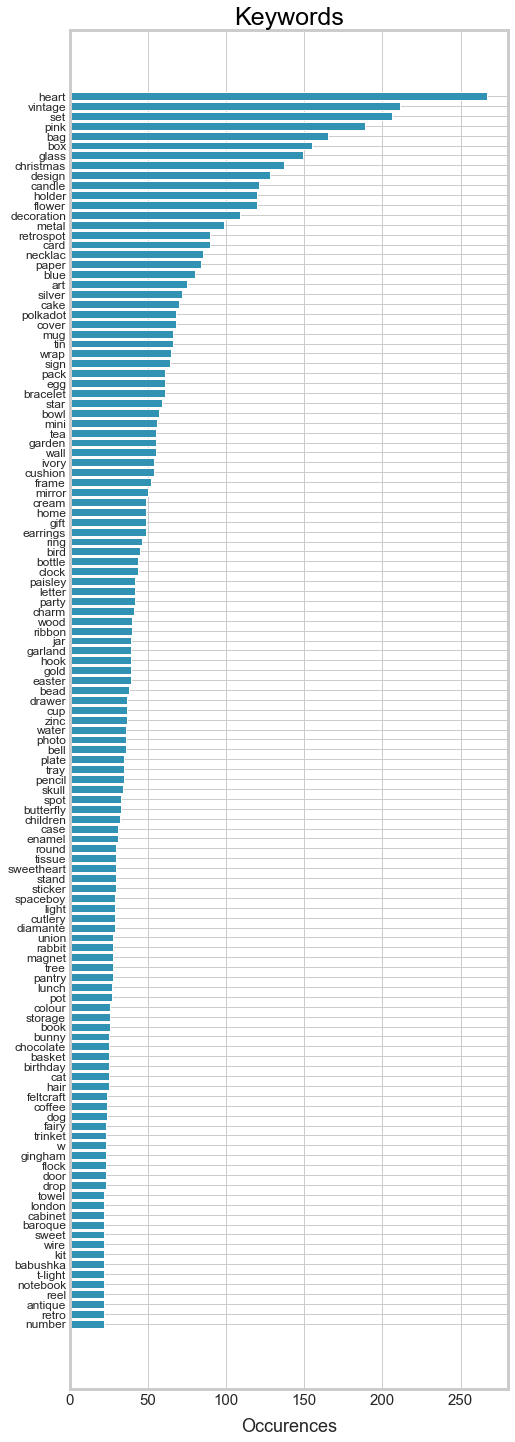

In [31]:
#Let's plot the keywords

lista = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in lista[:125]]
x_axis = [k for k,i in enumerate(lista[:125])]
x_label = [i[0] for i in lista[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)
plt.yticks(x_axis, x_label)
plt.xlabel("Occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center', color = '#3192B3')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Keywords",
         # bbox={'facecolor':'k', 'pad':5},
          color='black',fontsize = 25)
plt.show()

In [32]:
#Now we can divide the products into categories

list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('words kept:', len(list_products))

liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

words kept: 193


In [33]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [34]:
print("{:<8} {:<20} \n".format('gamma', 'no produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))
    


gamma    no produits          
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


In [35]:
matrix = X
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.1268004588393788
For n_clusters = 5 The average silhouette_score is : 0.14562442905455303
For n_clusters = 6 The average silhouette_score is : 0.1450621616291374
For n_clusters = 7 The average silhouette_score is : 0.14959907226711688
For n_clusters = 8 The average silhouette_score is : 0.14689677795453093
For n_clusters = 9 The average silhouette_score is : 0.13724506930089098


In [36]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
pd.Series(clusters).value_counts()

For n_clusters = 5 The average silhouette_score is : 0.14708700459493795


4    1009
1     964
3     762
0     673
2     470
dtype: int64

In [37]:
X.head()

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,flower,decoration,metal,retrospot,card,necklac,paper,art,silver,cake,polkadot,cover,mug,tin,wrap,sign,pack,egg,bracelet,star,bowl,mini,tea,garden,wall,ivory,cushion,frame,mirror,cream,home,gift,earrings,ring,bird,bottle,clock,paisley,letter,party,...,stripe,shape,parasol,cherry,travel,doilies,biscuit,regency,hen,jigsaw,rack,coaster,money,cottage,incense,crystal,medium,dish,image,picture,wooden,piece,bathroom,girl,fruit,childs,pan,food,orbit,alphabet,toadstool,time,milk,funky,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [38]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

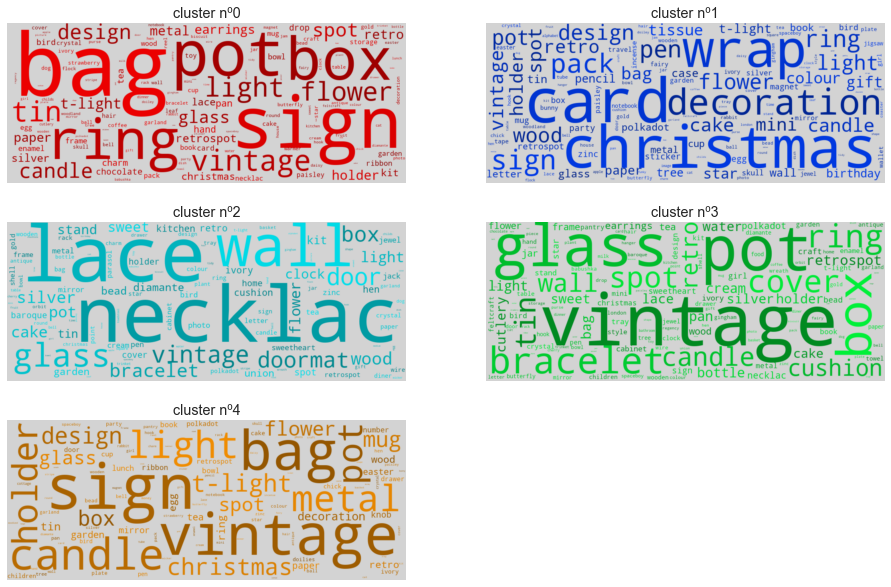

In [39]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)    

In [40]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

<a class="anchor" id="pre"></a>
# 4. Data Engineering

In [41]:
#Let's use a different kind of one hot encoder, instead of 1, let's put in the amount spent
for i in range(5):
    col = 'categ_' + str(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']].head(10)

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.0,0.0,0.00,0.00
1,536365,WHITE METAL LANTERN,3,0.0,0.0,0.0,20.34,0.00
2,536365,CREAM CUPID HEARTS COAT HANGER,3,0.0,0.0,0.0,22.00,0.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,3,0.0,0.0,0.0,20.34,0.00
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3,0.0,0.0,0.0,20.34,0.00
5,536365,SET 7 BABUSHKA NESTING BOXES,2,0.0,0.0,15.3,0.00,0.00
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,3,0.0,0.0,0.0,25.50,0.00
7,536366,HAND WARMER UNION JACK,0,11.1,0.0,0.0,0.00,0.00
8,536366,HAND WARMER RED POLKA DOT,4,0.0,0.0,0.0,0.00,11.10
9,536367,ASSORTED COLOUR BIRD ORNAMENT,4,0.0,0.0,0.0,0.00,54.08


In [42]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# pourcentage du prix de la commande / categorie de produit
for i in range(5):
    col = 'categ_' + str(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price[col] = temp[col] 
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True).head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,83.40,23.40,124.44,293.35,187.2,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,53.10,84.34,0.00,207.45,130.5,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,71.10,81.00,0.00,153.25,330.9,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,78.06,41.40,19.90,168.76,74.4,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,119.70,61.30,97.80,196.41,109.7,2011-08-02 08:48:00.000000000


In [43]:
#Investigating data for each customer
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True).head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,7,224.82,1294.32,615.714286,4310.00,20.805104,11.237123,7.604176,33.977726,26.375870
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,0.000000,20.030714,41.953217
2,12349,1,1757.55,1757.55,1757.550000,1757.55,12.245455,4.513101,20.389178,36.346050,26.506216
3,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.692584,0.000000,11.961722,48.444976
4,12352,7,144.35,840.30,340.815714,2385.71,4.071325,1.299404,14.691643,64.232451,15.705178


In [44]:
#How much time has passed from the first purchase to the last one?
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,20.805104,11.237123,7.604176,33.977726,26.375870,2,367
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,0.000000,20.030714,41.953217,75,358
2,12349,1,1757.55,1757.55,1757.550000,1757.55,12.245455,4.513101,20.389178,36.346050,26.506216,18,18
3,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.692584,0.000000,11.961722,48.444976,310,310
4,12352,7,144.35,840.30,340.815714,2385.71,4.071325,1.299404,14.691643,64.232451,15.705178,36,296


In [45]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("Number of customers with one purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

Number of customers with one purchase: 1489/4327  (34.41%)


In [46]:
transactions_per_user['recurrent'] = np.where(transactions_per_user['count'] == 1,0,
                                              transactions_per_user['FirstPurchase'] - transactions_per_user['LastPurchase'] )
temp = transactions_per_user[['CustomerID','count','recurrent','sum']]
df2 = pd.merge(df_cleaned, temp, on='CustomerID')

In [47]:
df2.drop(['InvoiceNo','Description','UnitPrice','InvoiceDate','StockCode','Quantity','recurrent'],axis=1,inplace=True)
df2.head()

,CustomerID,Country,QuantityCanceled,TotalPrice,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,count,sum
0,17850,United Kingdom,0,15.30,0,15.3,0.0,0.0,0.00,0.0,34,5322.84
1,17850,United Kingdom,0,20.34,3,0.0,0.0,0.0,20.34,0.0,34,5322.84
2,17850,United Kingdom,0,22.00,3,0.0,0.0,0.0,22.00,0.0,34,5322.84
3,17850,United Kingdom,0,20.34,3,0.0,0.0,0.0,20.34,0.0,34,5322.84
4,17850,United Kingdom,0,20.34,3,0.0,0.0,0.0,20.34,0.0,34,5322.84


In [48]:
customers = df2.groupby(['CustomerID','Country'], as_index = False).sum()
customers.head()

,CustomerID,Country,QuantityCanceled,TotalPrice,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,count,sum
0,12347,Iceland,0,4310.00,431,896.70,484.32,327.74,1464.44,1136.80,1274,784420.00
1,12348,Finland,0,1797.24,60,0.00,683.24,0.00,360.00,754.00,124,55714.44
2,12349,Italy,0,1757.55,174,215.22,79.32,358.35,638.80,465.86,73,128301.15
3,12350,Norway,0,334.40,42,93.30,39.10,0.00,40.00,162.00,17,5684.80
4,12352,Norway,63,2385.71,233,97.13,31.00,350.50,1532.40,374.68,595,202785.35


In [49]:
countries = customers.groupby('Country', as_index = False).sum().sort_values(by = 'count', ascending = False)

countries['country'] = [len(countries['Country'])-i for i in range(len(countries['Country']))]
countries.head()

,Country,QuantityCanceled,TotalPrice,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,count,sum,country
35,United Kingdom,157503,6828858.554,732976,1697453.96,795641.373,1125696.38,1643355.531,1573919.02,5709120,2.674117e+09,37
10,EIRE,4040,254839.400,15491,54241.10,28298.560,38245.05,83595.990,50893.21,1206296,9.350347e+08,36
23,Netherlands,328,284731.140,5163,77252.91,38328.590,11389.13,55365.920,102600.99,152940,5.824931e+08,35
14,Germany,1607,223435.730,19654,43909.03,26312.890,27540.51,71117.920,54568.13,87841,4.841451e+07,34
13,France,1580,196763.140,18137,42625.55,25175.030,20322.29,57808.690,55083.13,78660,4.889598e+07,33


In [50]:
customers.head()

,CustomerID,Country,QuantityCanceled,TotalPrice,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,count,sum
0,12347,Iceland,0,4310.00,431,896.70,484.32,327.74,1464.44,1136.80,1274,784420.00
1,12348,Finland,0,1797.24,60,0.00,683.24,0.00,360.00,754.00,124,55714.44
2,12349,Italy,0,1757.55,174,215.22,79.32,358.35,638.80,465.86,73,128301.15
3,12350,Norway,0,334.40,42,93.30,39.10,0.00,40.00,162.00,17,5684.80
4,12352,Norway,63,2385.71,233,97.13,31.00,350.50,1532.40,374.68,595,202785.35


In [51]:
customers = pd.merge(customers,countries[['Country','country']],on = 'Country')
customers.drop('Country',axis =1,inplace=True)
customers.head()

,CustomerID,QuantityCanceled,TotalPrice,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,count,sum,country
0,12347,0,4310.00,431,896.70,484.32,327.74,1464.44,1136.80,1274,784420.00,18
1,12348,0,1797.24,60,0.00,683.24,0.00,360.00,754.00,124,55714.44,26
2,12375,1,455.42,17,268.32,25.50,31.80,129.80,0.00,34,7742.14,26
3,12405,0,1710.39,99,354.61,213.72,360.40,625.70,155.96,54,92361.06,26
4,12428,33,7877.20,561,1248.69,886.99,1317.95,3418.88,1004.69,2646,2315896.80,26


In [52]:
from sklearn.preprocessing import normalize
IDs = customers['CustomerID']
customers.drop(['CustomerID','categ_product'],axis=1,inplace = True)


In [53]:
sum1 = customers['sum']
customers.drop(['count','sum'],axis=1,inplace = True)
#customers['QuantityCanceled'] = np.where(customers['QuantityCanceled']==0,0,1)

In [54]:
customers_n = normalize(customers) 

<a class="anchor" id="clus"></a>
# 5. Clustering

In [55]:
#Clustering with k means
cluster_range = range(2, 15)

km_WCSS_scores = []
km_sil_scores = []  # sil is nick name for silhouette

for kay in cluster_range:
    kh_mins = KMeans(n_clusters=kay)
    y_tmp = kh_mins.fit_predict(customers_n)  # y_tmp are the cluster results based on Xs (Stan-dar-dised)
    km_WCSS_scores.append(kh_mins.inertia_)  # that's how you get the score
    km_sil_scores.append(silhouette_score(customers, y_tmp))

<a class="anchor" id="elb"></a>
# 5.1 Elbow method

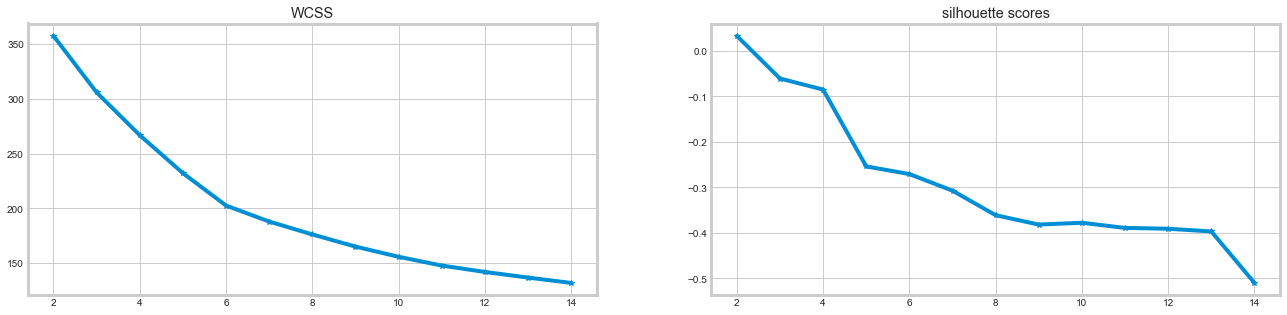

In [56]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title('WCSS')
plt.plot(cluster_range, km_WCSS_scores, marker='*')


plt.subplot(1, 2, 2)
plt.title('silhouette scores')
plt.plot(cluster_range, km_sil_scores, marker='*')

In [57]:
kmeans = KMeans(n_clusters= 3).fit(customers_n)

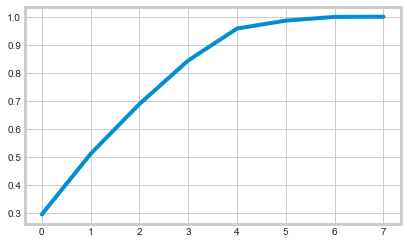

In [58]:
pca_test = PCA().fit(customers_n)
plt.plot(pca_test.explained_variance_ratio_.cumsum())
# the following plot tells us the variance we manage to get aganist the number of dimensions.

<a class="anchor" id="pca"></a>
# 5.2 PCA

In [59]:
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)
Xn_2d = pca_2d.fit_transform(customers_n)
Xn_3d = pca_3d.fit_transform(customers_n)


<AxesSubplot:>

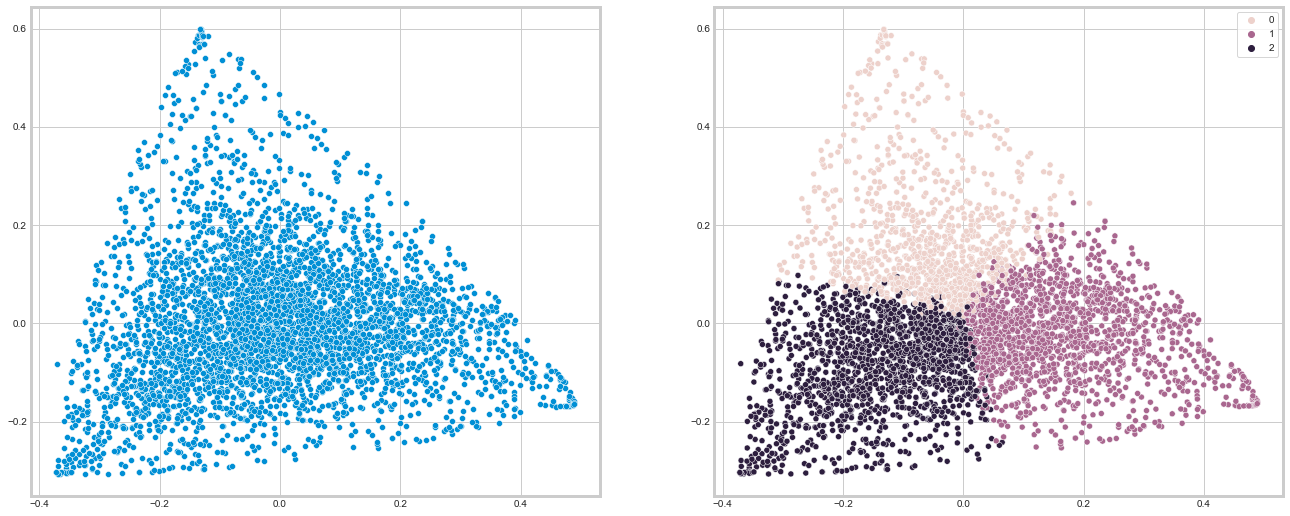

In [60]:
plt.figure(figsize=(20, 9))
x_, y_ = Xn_2d.T

plt.subplot(1, 2, 1)
sns.scatterplot(x=x_, y=y_)

plt.subplot(1, 2, 2)
sns.scatterplot(x=x_, y=y_, hue=kmeans.labels_)

In [61]:
pd.DataFrame(kmeans.labels_).value_counts()

1    1662
2    1612
0    1061
dtype: int64

In [62]:
import plotly.express as px

x_, y_, z_ = Xn_3d.T
fig = px.scatter_3d(x=x_, y=y_, z=z_, color=kmeans.labels_)
fig.show()

In [63]:
#Final sgmentation
Segmentation = pd.DataFrame()
Segmentation['CustomerID'] = IDs
Segmentation['Group'] = kmeans.labels_
Segmentation.head(15)

,CustomerID,Group
0,12347,1
1,12348,2
2,12375,0
3,12405,1
4,12428,1
5,12582,1
6,12587,0
7,12588,1
8,12630,1
9,12631,1


<a class="anchor" id="con"></a>
# 6. Conclusions

In [64]:
customers['sum'] = sum1
customers['label'] = kmeans.labels_
customers.head()

,QuantityCanceled,TotalPrice,categ_0,categ_1,categ_2,categ_3,categ_4,country,sum,label
0,0,4310.00,896.70,484.32,327.74,1464.44,1136.80,18,784420.00,1
1,0,1797.24,0.00,683.24,0.00,360.00,754.00,26,55714.44,2
2,1,455.42,268.32,25.50,31.80,129.80,0.00,26,7742.14,0
3,0,1710.39,354.61,213.72,360.40,625.70,155.96,26,92361.06,1
4,33,7877.20,1248.69,886.99,1317.95,3418.88,1004.69,26,2315896.80,1


In [65]:
customers.groupby('label').sum()

,QuantityCanceled,TotalPrice,categ_0,categ_1,categ_2,categ_3,categ_4,country,sum
label,,,,,,,,,
0,35934,2535970.291,1032916.21,237005.831,281170.70,461461.650,525120.62,38766,8.266032e+08
1,108184,3334606.942,524936.29,256101.711,806473.92,1200659.741,553564.57,59569,2.304810e+09
2,23491,2513530.941,464593.33,497506.691,208337.22,447375.700,899023.24,58404,1.318368e+09


In [66]:
customers.groupby('label').mean()

,QuantityCanceled,TotalPrice,categ_0,categ_1,categ_2,categ_3,categ_4,country,sum
label,,,,,,,,,
0,33.868049,2390.169926,973.530829,223.379671,265.005372,434.930867,494.929896,36.537229,7.790794e+05
1,65.092659,2006.382035,315.846143,154.092486,485.243032,722.418617,333.071342,35.841757,1.386769e+06
2,14.572581,1559.262370,288.209262,308.626980,129.241452,277.528350,557.706725,36.230769,8.178460e+05


 - __Label 0__: Customers that generally spend more in our ecommerce and they're more likely to be looking for vintage or decoration items

- __Label 1__: Customers that are more likely to cancel an order. They can be dissatisfied with the service. It is interesting to think about sending a NPS to collect some information on how to attract more people like them.

- __Label 2__: Customers that spend less than label 0, but they're satisfied with the service/products. They're looking for smaller items, from categ_0 (and that explains the less amount of money spent)